In [1]:
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as pd_sql
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, log_loss, classification_report 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler 

from imblearn.over_sampling import RandomOverSampler

# Load Data from PostgreSQL from AWS

In [6]:
connection_args = {
    'host': '18.224.137.185',  # You will need to put the PUBLIC IP address of your AWS instance here
    'user': 'ubuntu',    # your username on AWS is 'ubuntu'
    'dbname': 'echonest',    # DB that we are connecting to
    'port': 5432             # port we opened on AWS
}

connection = pg.connect(**connection_args)

In [7]:
fma_query = """
SELECT danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre 
FROM freemusicarchive
WHERE genre='Rock' OR genre='Electronic' OR genre='Hip-Hop';
"""
fma_df = pd_sql.read_sql(fma_query, connection)
fma_df.head(5)

danceability       energy  speechiness acousticness instrumentalness  \
0  0.675893985  0.634476268  0.159310065  0.416675233      0.010628068   
1  0.528643062  0.817461132  0.461818128  0.374407769      0.001851103   
2   0.74556587  0.701469992  0.124595342  0.043566899      0.000696799   
3   0.51323805  0.560409931  0.525519379  0.452217307      0.019442694   
4    0.2556609  0.979773793  0.051739762   0.98830555      0.973005724   

      liveness      valence    tempo    genre  
0  0.177646571  0.576660988  165.922  Hip-Hop  
1  0.105879944  0.269240242  126.957  Hip-Hop  
2  0.373143312  0.621661224   100.26  Hip-Hop  
3  0.096566694  0.894072272   114.29  Hip-Hop  
4     0.121342  0.034017867   90.241     Rock

In [9]:
billboard_query = """
SELECT danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
FROM billboard 
WHERE genre='Rock' OR genre='Electronic' OR genre='Hip-Hop';
"""
billboard_df = pd_sql.read_sql(billboard_query, connection)
billboard_df.head(5)

danceability energy speechiness acousticness instrumentalness liveness  \
0        0.452  0.794      0.0483       0.0111          0.00182    0.416   
1         0.81  0.793      0.0403       0.0378         1.82E-06    0.072   
2        0.832  0.659       0.057       0.0839          0.00114   0.0753   
3        0.804  0.451      0.0949        0.388         2.17E-05   0.0924   
4        0.775  0.585      0.0271       0.0422            0.619    0.077   

  valence    tempo       genre  
0   0.282  137.825  Electronic  
1   0.863  116.049  Electronic  
2   0.674  100.163  Electronic  
3    0.19  178.061  Electronic  
4   0.518  109.942  Electronic

In [10]:
fma_df.shape

(5947, 9)

In [11]:
billboard_df.shape

(2830, 9)

In [12]:
genre_query = """
SELECT danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre 
FROM freemusicarchive 
WHERE genre='Rock' OR genre='Electronic' OR genre='Hip-Hop'

UNION


SELECT danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre 
FROM billboard WHERE genre='Rock' OR genre='Electronic' OR genre='Hip-Hop'
;
"""

In [13]:
genre_df = pd_sql.read_sql(genre_query, connection)
genre_df.shape

(8446, 9)

In [14]:
with open('genre_data.pickle', 'wb') as to_write:
    pickle.dump(genre_df, to_write)

# Exploratory Data Analysis

In [3]:
with open('genre_data.pickle','rb') as read_file:
    genre_df = pickle.load(read_file)

In [4]:
genre_df['genre'].value_counts()

Rock          4169
Electronic    2245
Hip-Hop       2032
Name: genre, dtype: int64

Class imbalance. We'll have to address this

In [5]:
genre_df.dtypes

danceability        object
energy              object
speechiness         object
acousticness        object
instrumentalness    object
liveness            object
valence             object
tempo               object
genre               object
dtype: object

Change data types to floats.

In [6]:
genre_df['danceability'] = pd.to_numeric(genre_df['danceability'], errors='coerce')
genre_df['energy'] = pd.to_numeric(genre_df['energy'], errors='coerce')
genre_df['speechiness'] = pd.to_numeric(genre_df['speechiness'], errors='coerce')
genre_df['acousticness'] = pd.to_numeric(genre_df['acousticness'], errors='coerce')
genre_df['instrumentalness'] = pd.to_numeric(genre_df['instrumentalness'], errors='coerce')
genre_df['liveness'] = pd.to_numeric(genre_df['liveness'], errors='coerce')
genre_df['valence'] = pd.to_numeric(genre_df['valence'], errors='coerce')
genre_df['tempo'] = pd.to_numeric(genre_df['tempo'], errors='coerce')
genre_df.dtypes

danceability        float64
energy              float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
genre                object
dtype: object

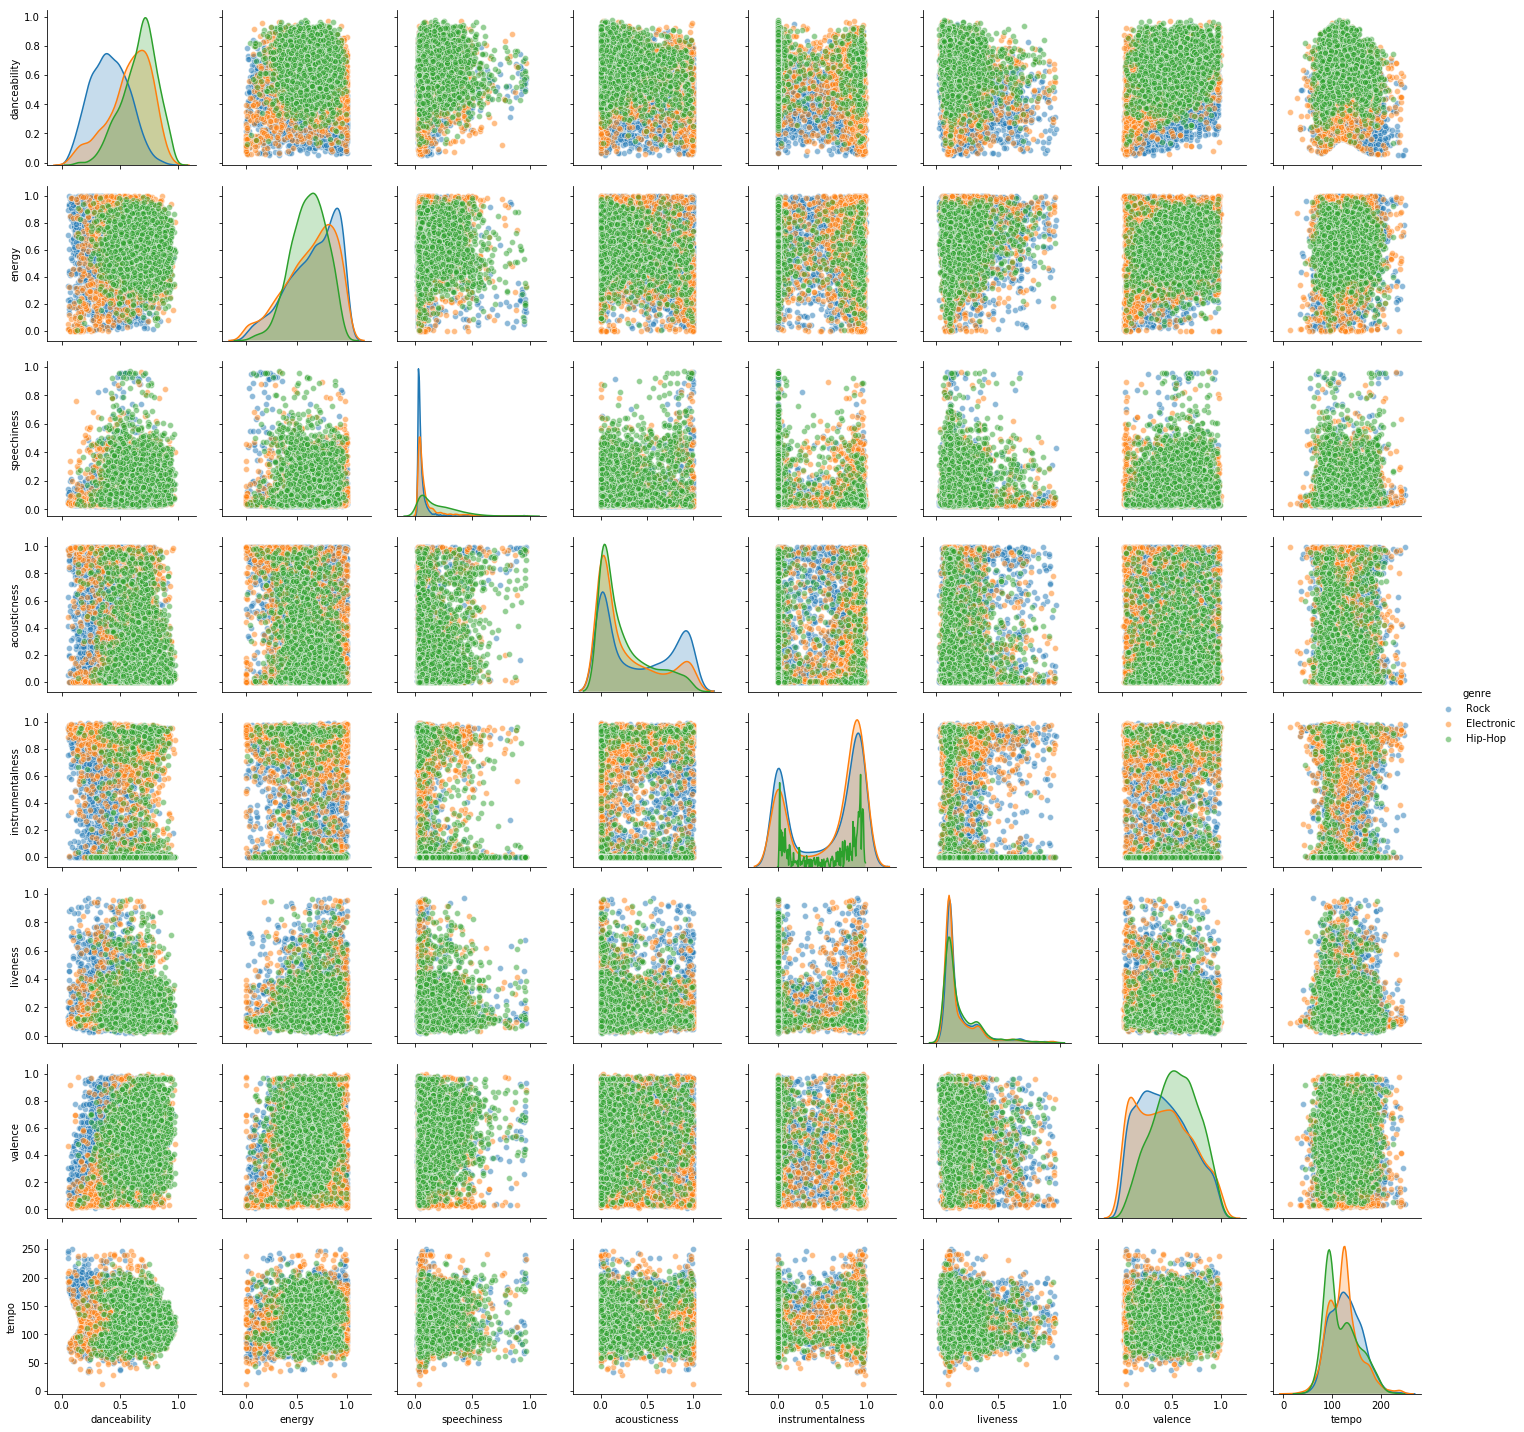

In [7]:
sns.pairplot(genre_df, hue = 'genre', plot_kws={'alpha':0.5})

Instrumentalness and liveliness may not be good predictors

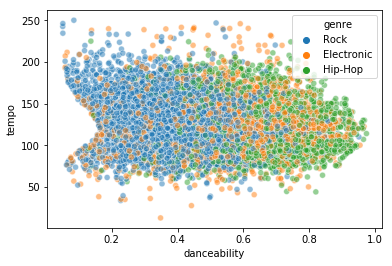

In [52]:
sns.scatterplot(genre_df['danceability'], genre_df['tempo'], hue=genre_df['genre'], alpha=0.5)

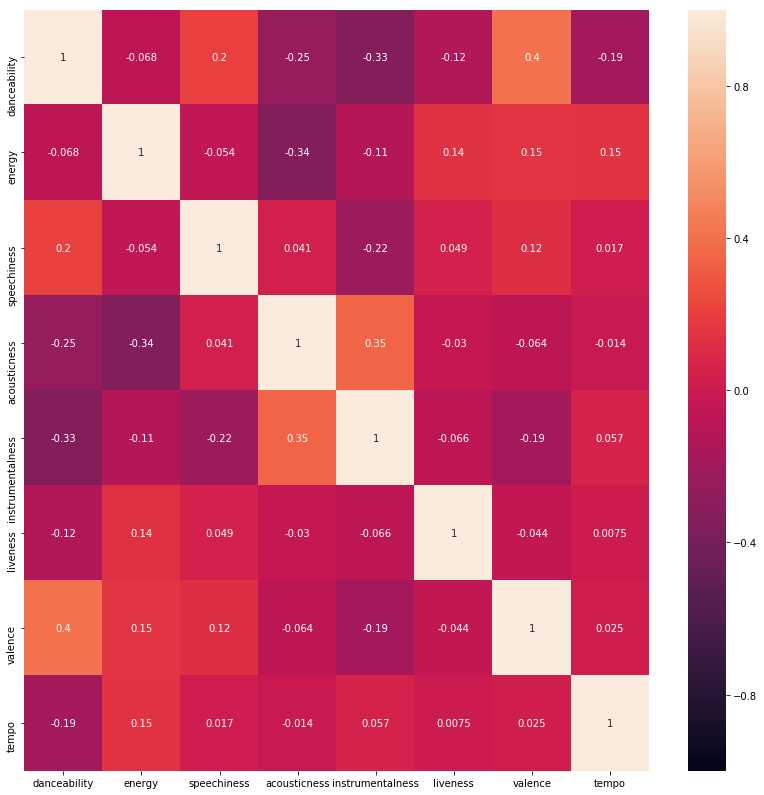

In [59]:
plt.figure(figsize=(14,14))
sns.heatmap(genre_df[['danceability',
              'energy',
              'speechiness',
              'acousticness',
              'instrumentalness',
              'liveness',
              'valence',
              'tempo']].corr(), annot=True, vmin=-1, vmax=1)

No strong correlations between any of our features. Not useful for feature engineering.

# Binary Classification (Rock vs Not Rock)

In [7]:
rock_df = genre_df.copy()
rock_df.loc[rock_df['genre'] == 'Electronic', 'genre'] = 0
rock_df.loc[rock_df['genre'] == 'Hip-Hop', 'genre'] = 0
rock_df.loc[rock_df['genre'] == 'Rock', 'genre'] = 1
rock_df['genre'].value_counts()

0    4277
1    4169
Name: genre, dtype: int64

In [8]:
rock_df.head(5)

danceability    energy  speechiness  acousticness  instrumentalness  \
0      0.246707  0.626093     0.036625      0.750522          0.887763   
1      0.330716  0.512588     0.030868      0.000002          0.950499   
2      0.684000  0.845000     0.053400      0.002150          0.004840   
3      0.575000  0.765000     0.034500      0.007030          0.000000   
4      0.596000  0.878000     0.033700      0.065200          0.843000   

   liveness   valence    tempo  genre  
0  0.072542  0.402326  140.061      1  
1  0.106463  0.195356   93.709      0  
2  0.643000  0.828000  130.015      0  
3  0.331000  0.407000   98.037      1  
4  0.296000  0.461000  126.043      0

In [9]:
rock_df.groupby('genre').mean()

danceability    energy  speechiness  acousticness  instrumentalness  \
genre                                                                        
0          0.623651  0.628911     0.149729      0.263757          0.372219   
1          0.414523  0.666193     0.068220      0.422172          0.543398   

       liveness   valence       tempo  
genre                                  
0      0.184603  0.477200  121.164267  
1      0.190206  0.423359  128.261440

In [10]:
X = rock_df[['danceability',
              'energy',
              'speechiness',
              'acousticness',
              'instrumentalness',
              'liveness',
              'valence',
              'tempo']]

label = rock_df['genre']

In [11]:
# As usual, create our train/test split
# This will become particularly important as we calculate our error metrics

X_train, X_test, label_train, label_test = train_test_split(X, label, test_size=0.3, random_state=41)

In [12]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, label_train)
print("The score for kNN is")
print("Training: {:6.2f}%".format(100*knn.score(X_train, label_train)))
print("Test set: {:6.2f}%".format(100*knn.score(X_test, label_test)))

The score for kNN is
Training:  81.72%
Test set:  70.48%


In [13]:
logit = LogisticRegression(C = 0.95)
logit.fit(X_train, label_train)
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*logit.score(X_train, label_train)))
print("Test set: {:6.2f}%".format(100*logit.score(X_test, label_test)))

The score for logistic regression is
Training:  79.19%
Test set:  78.97%


/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [14]:
def print_models_binary_classification(X_train, label_train, X_test, label_test):

    models = {
        "KNN": KNeighborsClassifier(n_neighbors=5),
        "Logistic": LogisticRegression(random_state = 4444),
        "NB": GaussianNB(),
        "SVC": SVC(random_state = 4444, probability=True),
        "Decision Tree": DecisionTreeClassifier(random_state=4444),
        "Random Forest": RandomForestClassifier(random_state=4444)
    }

    for key in models.keys():
        model_fit = models[key].fit(X_train, label_train)
        model_accuracy = accuracy_score(label_test, models[key].predict(X_test))
        model_precision = precision_score(label_test, models[key].predict(X_test))
        model_recall = recall_score(label_test, models[key].predict(X_test))
        model_f1 = f1_score(label_test, models[key].predict(X_test))
        print("\n\nModel: " + str(key) + "\nAccuracy: " + str(model_accuracy) + "\nPrecision: " + str(model_precision)
              + "\nRecall: "+ str(model_recall) + "\nF1: " + str(model_f1))

    plt.figure(figsize = (10,7))
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])


    for key in models.keys():
        fpr, tpr, thresholds = roc_curve(label_test, models[key].predict_proba(X_test)[:, 1])
        plt.plot(fpr, tpr,lw=2, label=key) 
        #print('\nFalse Positive Rates: ', fpr)
        #print('\nTrue Positive Rates: ', tpr)
        #print('\nThreshold Levels: ', thresholds)
        print("\nROC AUC score for " + key +  " = " + str(roc_auc_score(label_test, models[key].predict_proba(X_test)[:, 1])))

    plt.legend(loc=0)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')



Model: KNN
Accuracy: 0.7048145224940805
Precision: 0.6994448850118953
Recall: 0.7050359712230215
F1: 0.7022292993630573


Model: Logistic
Accuracy: 0.7892659826361483
Precision: 0.7879518072289157
Recall: 0.7841726618705036
F1: 0.7860576923076922


Model: NB
Accuracy: 0.7636148382004736
Precision: 0.7492354740061162
Recall: 0.7833733013589129
F1: 0.7659241891363814


/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)




Model: SVC
Accuracy: 0.7154696132596685
Precision: 0.7054263565891473
Recall: 0.7274180655475619
F1: 0.7162534435261707


Model: Decision Tree
Accuracy: 0.7565114443567482
Precision: 0.7606907894736842
Recall: 0.7394084732214229
F1: 0.7498986623429267


Model: Random Forest
Accuracy: 0.8109707971586425
Precision: 0.8260135135135135
Recall: 0.7817745803357314
F1: 0.8032854209445586


/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



ROC AUC score for KNN = 0.7572554582989882

ROC AUC score for Logistic = 0.8563559129313854

ROC AUC score for NB = 0.8260456327066171

ROC AUC score for SVC = 0.7951397260990894

ROC AUC score for Decision Tree = 0.7565056294792692

ROC AUC score for Random Forest = 0.8843849316493804


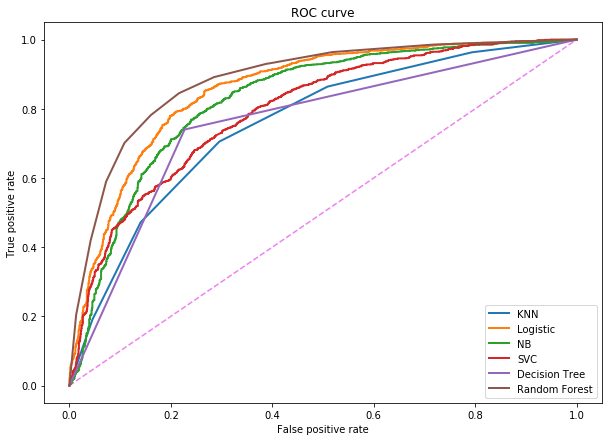

In [15]:
print_models_binary_classification(X_train, label_train, X_test, label_test)

Random Forest is our best model

In [16]:
rf = RandomForestClassifier(random_state=4444)
rf.fit(X_train, label_train)
y_predict = rf.predict(X_test)
rf_confusion_matrix = confusion_matrix(label_test, y_predict)
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), X_train.columns)))
    
    
print("\nRandom Forest confusion matrix: \n\n", rf_confusion_matrix)


y_predict_proba = rf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(label_test, y_predict_proba[:, 1])
print('\nFalse Positive Rates: ', fpr)
print('\nTrue Positive Rates: ', tpr)
print('\nThreshold Levels: ', thresholds)

print(sorted(list(zip(tpr - fpr, thresholds))))



[(0.0551, 'liveness'), (0.0772, 'tempo'), (0.0786, 'valence'), (0.1026, 'energy'), (0.1102, 'acousticness'), (0.1144, 'instrumentalness'), (0.1953, 'speechiness'), (0.2667, 'danceability')]

Random Forest confusion matrix: 

 [[1077  206]
 [ 273  978]]

False Positive Rates:  [0.         0.01325019 0.04130943 0.04130943 0.07170694 0.07170694
 0.10833983 0.16056118 0.21590023 0.28604832 0.28682775 0.38971161
 0.39127046 0.51909587 0.51987529 0.71784879 0.71862822 1.        ]

True Positive Rates:  [0.         0.20463629 0.41566747 0.41646683 0.58593125 0.58752998
 0.70103917 0.78177458 0.84492406 0.89208633 0.89208633 0.93045564
 0.93045564 0.96402878 0.96402878 0.98561151 0.98561151 1.        ]

Threshold Levels:  [2.         1.         0.9        0.825      0.8        0.75
 0.7        0.6        0.5        0.4        0.35       0.3
 0.23333333 0.2        0.14       0.1        0.06666667 0.        ]
[(0.0, 0.0), (0.0, 2.0), (0.19138609611141952, 1.0), (0.26698329567055623, 0.0666666666

/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Best threshold level is 0.5

# Multiclass Classification

In [8]:
genre_df.loc[genre_df['genre'] == 'Electronic', 'genre'] = 0
genre_df.loc[genre_df['genre'] == 'Hip-Hop', 'genre'] = 1
genre_df.loc[genre_df['genre'] == 'Rock', 'genre'] = 2
genre_df.head(5)

danceability    energy  speechiness  acousticness  instrumentalness  \
0      0.246707  0.626093     0.036625      0.750522          0.887763   
1      0.330716  0.512588     0.030868      0.000002          0.950499   
2      0.684000  0.845000     0.053400      0.002150          0.004840   
3      0.575000  0.765000     0.034500      0.007030          0.000000   
4      0.596000  0.878000     0.033700      0.065200          0.843000   

   liveness   valence    tempo  genre  
0  0.072542  0.402326  140.061      2  
1  0.106463  0.195356   93.709      0  
2  0.643000  0.828000  130.015      0  
3  0.331000  0.407000   98.037      2  
4  0.296000  0.461000  126.043      0

In [9]:
genre_df.groupby('genre').mean()

danceability    energy  speechiness  acousticness  instrumentalness  \
genre                                                                        
0          0.585293  0.636898     0.103938      0.278695          0.596775   
1          0.666030  0.620086     0.200319      0.247253          0.124125   
2          0.414523  0.666193     0.068220      0.422172          0.543398   

       liveness   valence       tempo  
genre                                  
0      0.178908  0.421412  123.238690  
1      0.190894  0.538837  118.872398  
2      0.190206  0.423359  128.261440

In [10]:
genre_df.groupby('genre')['danceability'].describe()

count      mean       std       min       25%       50%       75%  \
genre                                                                       
0      2245.0  0.585293  0.185587  0.057996  0.480259  0.615575  0.725000   
1      2032.0  0.666030  0.150897  0.129479  0.572625  0.688191  0.771395   
2      4169.0  0.414523  0.162558  0.051307  0.291029  0.408665  0.531595   

            max  
genre            
0      0.966883  
1      0.974000  
2      0.951000

Hip Hop has high danceability.

In [11]:
genre_df.groupby('genre')['energy'].describe()

count      mean       std       min       25%       50%       75%  \
genre                                                                       
0      2245.0  0.636898  0.245724  0.000020  0.475781  0.681575  0.835266   
1      2032.0  0.620086  0.173518  0.007619  0.503709  0.629178  0.749000   
2      4169.0  0.666193  0.241621  0.001594  0.498627  0.709000  0.871713   

            max  
genre            
0      0.999964  
1      0.990904  
2      0.999768

No distinguishibility in energy.

In [12]:
genre_df.groupby('genre')['speechiness'].describe()

count      mean       std       min       25%       50%       75%  \
genre                                                                       
0      2245.0  0.103938  0.116032  0.024160  0.042253  0.059801  0.104549   
1      2032.0  0.200319  0.165623  0.023234  0.066029  0.151903  0.288184   
2      4169.0  0.068220  0.091373  0.023564  0.035443  0.045122  0.065045   

            max  
genre            
0      0.963053  
1      0.966177  
2      0.964073

Hip Hop has high speechiness value.

In [13]:
genre_df.groupby('genre')['acousticness'].describe()

count      mean       std           min       25%       50%       75%  \
genre                                                                           
0      2245.0  0.278695  0.327685  9.030000e-07  0.013400  0.118000  0.478981   
1      2032.0  0.247253  0.268321  8.810000e-06  0.033025  0.137632  0.392279   
2      4169.0  0.422172  0.381666  9.490000e-07  0.017800  0.349849  0.828017   

            max  
genre            
0      0.995796  
1      0.991431  
2      0.995796

Rock has high acousticness value.

In [14]:
genre_df.groupby('genre')['liveness'].describe()

count      mean       std     min       25%       50%       75%  \
genre                                                                     
0      2245.0  0.178908  0.150919  0.0279  0.094796  0.114863  0.205349   
1      2032.0  0.190894  0.148091  0.0215  0.096619  0.127039  0.246000   
2      4169.0  0.190206  0.150969  0.0200  0.103433  0.125046  0.226297   

            max  
genre            
0      0.959185  
1      0.962000  
2      0.971392

Not a huge impact

In [15]:
genre_df.groupby('genre')['instrumentalness'].describe()

count      mean       std  min       25%           50%       75%  \
genre                                                                      
0      2245.0  0.596775  0.385521  0.0  0.070526  8.195529e-01  0.906861   
1      2032.0  0.124125  0.289246  0.0  0.000000  1.001500e-07  0.002932   
2      4169.0  0.543398  0.399771  0.0  0.015604  7.501517e-01  0.908520   

            max  
genre            
0      0.991022  
1      0.982635  
2      0.993134

Hip Hop low in instrumentalness. Electronic high in instrumentalness.

In [16]:
genre_df.groupby('genre')['valence'].describe()

count      mean       std       min       25%       50%       75%  \
genre                                                                       
0      2245.0  0.421412  0.273917  0.009059  0.179300  0.406602  0.636000   
1      2032.0  0.538837  0.221803  0.031204  0.377262  0.545260  0.706000   
2      4169.0  0.423359  0.253298  0.014392  0.215442  0.400000  0.612542   

            max  
genre            
0      0.999990  
1      0.983199  
2      0.983149

Hip-Hop high in valence

In [17]:
genre_df.groupby('genre')['tempo'].describe()

count        mean        std     min      25%       50%      75%  \
genre                                                                      
0      2245.0  123.238690  32.056903  12.753  100.011  122.9880  139.992   
1      2032.0  118.872398  33.649843  43.988   92.519  109.9115  142.021   
2      4169.0  128.261440  32.073105  33.616  103.859  126.4700  150.384   

           max  
genre           
0      245.888  
1      224.955  
2      250.059

No distinguishibility in tempo.

In [18]:
genre_df['genre'].value_counts()

2    4169
0    2245
1    2032
Name: genre, dtype: int64

## Modeling

### Baseline

In [19]:
X = genre_df[['danceability',
              'energy',
              'speechiness',
              'acousticness',
              'instrumentalness',
              'liveness',
              'valence',
              'tempo']]

label = genre_df['genre']

In [20]:
# As usual, create our train/test split
# This will become particularly important as we calculate our error metrics

X_train, X_test, label_train, label_test = train_test_split(X, label, test_size=0.3, random_state=41)

In [21]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)

In [149]:
models = {
    "KNN": [ KNeighborsClassifier(n_neighbors=5), X_train_scaled, X_test_scaled] , 
    "Logistic": [ LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state = 4444), X_train_scaled, X_test_scaled] ,
    "NB": [ GaussianNB(), X_train, X_test] ,
    "SVC": [ OneVsRestClassifier(SVC(random_state = 4444, probability=True)), X_train_scaled, X_test_scaled],
    "Decision Tree": [ DecisionTreeClassifier(random_state=4444), X_train, X_test] ,
    "Random Forest": [ RandomForestClassifier(random_state=4444), X_train, X_test]
}

for key in models.keys():
    model_fit = models[key][0].fit(models[key][1], label_train)
    model_accuracy = accuracy_score(label_train, models[key][0].predict(models[key][1]))
    model_precision = precision_score(label_train, models[key][0].predict(models[key][1]), average='weighted')
    model_recall = recall_score(label_train, models[key][0].predict(models[key][1]), average='weighted')
    model_f1 = f1_score(label_train, models[key][0].predict(models[key][1]), average='weighted')        
    model_log_loss = log_loss(label_train, models[key][0].predict_proba(models[key][1]))
    print("\n\nTrain Model: " + str(key) + "\nAccuracy: " + str(model_accuracy) + "\nPrecision: " + str(model_precision)
            + "\nRecall: "+ str(model_recall) + "\nF1: " + str(model_f1) + "\nLog-Loss: " + str(model_log_loss)) 
    
    
    model_fit = models[key][0].fit(models[key][1], label_train)
    model_accuracy = accuracy_score(label_test, models[key][0].predict(models[key][2]))
    model_precision = precision_score(label_test, models[key][0].predict(models[key][2]), average='weighted')
    model_recall = recall_score(label_test, models[key][0].predict(models[key][2]), average='weighted')
    model_f1 = f1_score(label_test, models[key][0].predict(models[key][2]), average='weighted')        
    model_log_loss = log_loss(label_test, models[key][0].predict_proba(models[key][2]))
    print("\n\nTest Model: " + str(key) + "\nAccuracy: " + str(model_accuracy) + "\nPrecision: " + str(model_precision)
            + "\nRecall: "+ str(model_recall) + "\nF1: " + str(model_f1) + "\nLog-Loss: " + str(model_log_loss)) 



Train Model: KNN
Accuracy: 0.8066644113667117
Precision: 0.8043539680500812
Recall: 0.8066644113667117
F1: 0.8050151433571029
Log-Loss: 0.4092746223760741


Test Model: KNN
Accuracy: 0.7103393843725335
Precision: 0.706491139787506
Recall: 0.7103393843725335
F1: 0.7079779173050078
Log-Loss: 3.029186155075666


Train Model: Logistic
Accuracy: 0.726319350473613
Precision: 0.7211630320617782
Recall: 0.726319350473613
F1: 0.7147668930019994
Log-Loss: 0.7078532288423041


Test Model: Logistic
Accuracy: 0.7162588792423047
Precision: 0.7115910481791674
Recall: 0.7162588792423047
F1: 0.7057324413519708
Log-Loss: 0.7093129309364988


Train Model: NB
Accuracy: 0.7023004059539919
Precision: 0.704481775399003
Recall: 0.7023004059539919
F1: 0.6853104099320634
Log-Loss: 0.8665040559084626


Test Model: NB
Accuracy: 0.6866614048934491
Precision: 0.6923627058457419
Recall: 0.6866614048934491
F1: 0.6698428309110803
Log-Loss: 0.8539587227765798


Train Model: SVC
Accuracy: 0.7745263870094723
Precision:

/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)




Train Model: Random Forest
Accuracy: 0.9893437077131259
Precision: 0.9893534173221553
Recall: 0.9893437077131259
F1: 0.9893476509870149
Log-Loss: 0.15301889551409756


Test Model: Random Forest
Accuracy: 0.749802683504341
Precision: 0.7469120150899005
Recall: 0.749802683504341
F1: 0.7481068546883941
Log-Loss: 1.5169626205190418


### OverSampler

In [150]:
# As usual, create our train/test split
# This will become particularly important as we calculate our error metrics

X_train, X_test, label_train, label_test = train_test_split(X, label, test_size=0.3, random_state=41)

In [151]:
#ros = RandomOverSampler(random_state=0)
#X_train, label_train = ros.fit_sample(X_train,label_train)

from imblearn.over_sampling import SMOTE
X_train, label_train = SMOTE(random_state=42).fit_sample(X_train,label_train)

In [152]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [153]:
models = {
    "KNN": [ KNeighborsClassifier(n_neighbors=5), X_train_scaled, X_test_scaled] , 
    "Logistic": [ LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state = 4444), X_train_scaled, X_test_scaled] ,
    "NB": [ GaussianNB(), X_train, X_test] ,
    "SVC": [ OneVsRestClassifier(SVC(random_state = 4444, probability=True)), X_train_scaled, X_test_scaled],
    "Decision Tree": [ DecisionTreeClassifier(random_state=4444), X_train, X_test] ,
    "Random Forest": [ RandomForestClassifier(random_state=4444), X_train, X_test]
}

for key in models.keys():
    model_fit = models[key][0].fit(models[key][1], label_train)
    model_accuracy = accuracy_score(label_train, models[key][0].predict(models[key][1]))
    model_precision = precision_score(label_train, models[key][0].predict(models[key][1]), average='weighted')
    model_recall = recall_score(label_train, models[key][0].predict(models[key][1]), average='weighted')
    model_f1 = f1_score(label_train, models[key][0].predict(models[key][1]), average='weighted')        
    model_log_loss = log_loss(label_train, models[key][0].predict_proba(models[key][1]))
    print("\n\nTrain Model: " + str(key) + "\nAccuracy: " + str(model_accuracy) + "\nPrecision: " + str(model_precision)
            + "\nRecall: "+ str(model_recall) + "\nF1: " + str(model_f1) + "\nLog-Loss: " + str(model_log_loss)) 
    
    
    model_fit = models[key][0].fit(models[key][1], label_train)
    model_accuracy = accuracy_score(label_test, models[key][0].predict(models[key][2]))
    model_precision = precision_score(label_test, models[key][0].predict(models[key][2]), average='weighted')
    model_recall = recall_score(label_test, models[key][0].predict(models[key][2]), average='weighted')
    model_f1 = f1_score(label_test, models[key][0].predict(models[key][2]), average='weighted')        
    model_log_loss = log_loss(label_test, models[key][0].predict_proba(models[key][2]))
    print("\n\nTest Model: " + str(key) + "\nAccuracy: " + str(model_accuracy) + "\nPrecision: " + str(model_precision)
            + "\nRecall: "+ str(model_recall) + "\nF1: " + str(model_f1) + "\nLog-Loss: " + str(model_log_loss)) 



Train Model: KNN
Accuracy: 0.8534384281471328
Precision: 0.8542190687428097
Recall: 0.8534384281471328
F1: 0.8531559777513492
Log-Loss: 0.3205932874190067


Test Model: KNN
Accuracy: 0.6819258089976322
Precision: 0.6975414495138385
Recall: 0.6819258089976322
F1: 0.6863997802062315
Log-Loss: 3.996791448792331


Train Model: Logistic
Accuracy: 0.7124742974640165
Precision: 0.710839696956756
Recall: 0.7124742974640165
F1: 0.7085074609278023
Log-Loss: 0.70798491790099


Test Model: Logistic
Accuracy: 0.696921862667719
Precision: 0.7053506030755622
Recall: 0.696921862667719
F1: 0.6969814920245921
Log-Loss: 0.7388652518175416


Train Model: NB
Accuracy: 0.6932830705962988
Precision: 0.6952754770815545
Recall: 0.6932830705962988
F1: 0.6867311348597758
Log-Loss: 0.8659559824416826


Test Model: NB
Accuracy: 0.6610102604577742
Precision: 0.6753923280513857
Recall: 0.6610102604577742
F1: 0.659720697460938
Log-Loss: 0.9424132502078835


Train Model: SVC
Accuracy: 0.7876399360292438
Precision: 0

/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)




Train Model: Random Forest
Accuracy: 0.9929175234178661
Precision: 0.9929339336845772
Recall: 0.9929175234178661
F1: 0.9929167299586191
Log-Loss: 0.1311520701404886


Test Model: Random Forest
Accuracy: 0.7336227308602999
Precision: 0.7426667992331143
Recall: 0.7336227308602999
F1: 0.7364577832917847
Log-Loss: 1.7048411242620394


### Conclusions

Oversampling improves SVC slightly in terms of accuracy, recall, and f1. It also improves recall slightly for a few other models. But overall, it shows a negative impact on many metrics. While accuracy isn't a good metric in regards to oversampling, other metrics should have some noticeable impact. So oversampling does little to improve model performance. 

There is serious overfitting in Decision Trees and Random Forest. Hyperparameter tuning needs to happen

## ROC Curves / AOC Values For Three Best Models

In [22]:
def print_roc_curves(classifier, X, label, standard_scaler):
    
    label = label_binarize(label, classes=[0,1,2])
    n_classes = 3
    
    # shuffle and split training and test sets
    X_train, X_test, label_train, label_test =\
    train_test_split(X, label, test_size=0.33, random_state=0)
    
    #from imblearn.over_sampling import SMOTE
    #X_train, label_train = SMOTE(random_state=42).fit_sample(X_train,label_train)
    
    if standard_scaler == True:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    # classifier
    #label_score = classifier.fit(X_train, label_train).predict_proba(X_test)
    label_fit = classifier.fit(X_train, label_train)
    label_score = label_fit.predict_proba(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(label_test[:, i], label_score[i][:, 1])
        roc_auc[i] = auc(fpr[i], tpr[i])
        print("Optimal Threshold for Class %0.2f" % i)
        print(sorted(list(zip(tpr[i] - fpr[i], _)))[-1])
        
    # Plot of a ROC curve for a specific class
    for i in range(n_classes):
        plt.figure()
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example for class %0.2f' % i)
        plt.legend(loc="lower right")
        plt.show()

In [23]:
def print_roc_curves_standard(classifier, X, label, standard_scaler):
    
    label = label_binarize(label, classes=[0,1,2])
    n_classes = 3
    
    # shuffle and split training and test sets
    X_train, X_test, label_train, label_test =\
    train_test_split(X, label, test_size=0.33, random_state=0)
    
    #from imblearn.over_sampling import SMOTE
    #X_train, label_train = SMOTE(random_state=42).fit_sample(X_train,label_train)
    
    if standard_scaler == True:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    # classifier
    label_score = classifier.fit(X_train, label_train).predict_proba(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(label_test[:, i], label_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        print("Optimal Threshold for Class %0.2f" % i)
        print(sorted(list(zip(tpr[i] - fpr[i], _)))[-1])

    # Plot of a ROC curve for a specific class
    for i in range(n_classes):
        plt.figure()
        plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example for class %0.2f' % i)
        plt.legend(loc="lower right")
        plt.show()

### Random Forest

/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Optimal Threshold for Class 0.00
(0.4705797828356084, 0.3)
Optimal Threshold for Class 1.00
(0.7239563567362429, 0.3)
Optimal Threshold for Class 2.00
(0.62108664999331, 0.5)


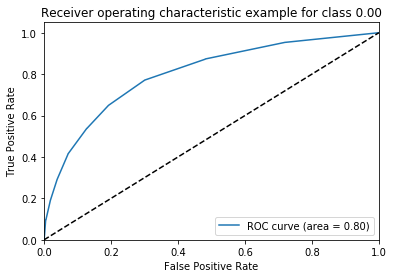

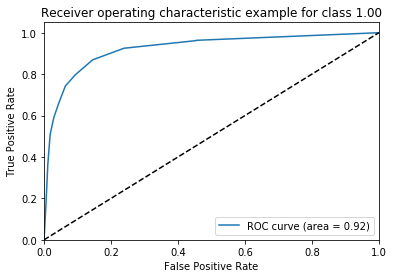

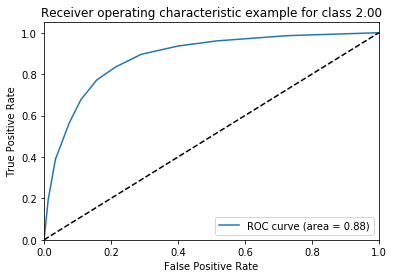

In [24]:
# classifier
print_roc_curves(RandomForestClassifier(random_state=4444), X, label, False)

### SVC

Optimal Threshold for Class 0.00
(0.517823204869254, 0.1967220938614517)
Optimal Threshold for Class 1.00
(0.7248576850094877, 0.12475977633259415)
Optimal Threshold for Class 2.00
(0.6463159086464734, 0.5)


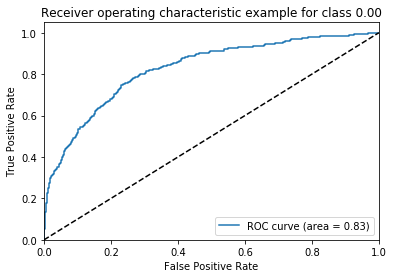

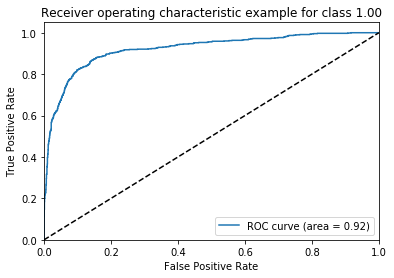

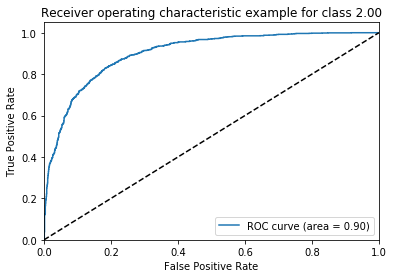

In [159]:
print_roc_curves_standard(OneVsRestClassifier(SVC(random_state = 4444, probability=True)), X, label, True)

### Logistic Regression

Optimal Threshold for Class 0.00
(0.33412409006493243, 0.26506187470464243)
Optimal Threshold for Class 1.00
(0.6686432637571158, 0.3815629323272037)
Optimal Threshold for Class 2.00
(0.5821306902975474, 0.4111815275744052)


/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


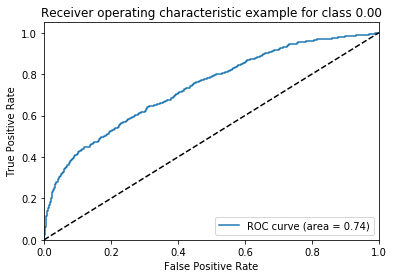

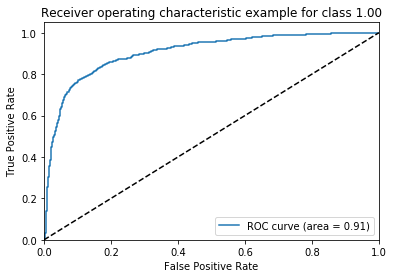

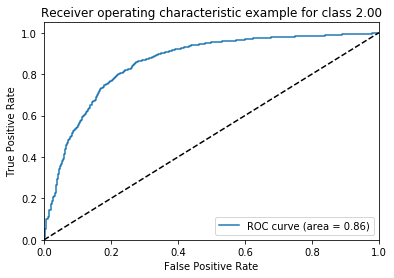

In [160]:
print_roc_curves_standard(OneVsRestClassifier(LogisticRegression( random_state = 4444)), X, label, True)

### Conclusions

Random Forest and SVC are the top two models based on accuracy, precision, recall, and f1. But Logistic was included as it had a lower log-loss. 

For our three models in terms of AUC, SVC outperforms all models in each class. Makes no sense to ensemble.

# Hyperparameter Tuning

## Random Forest Classifier

In [18]:
X = genre_df[['danceability',
              'energy',
              'speechiness',
              'acousticness',
              'instrumentalness',
              'liveness',
              'valence',
              'tempo']]

label = genre_df['genre']

In [19]:
X_train, X_test, label_train, label_test = train_test_split(X, label, test_size=0.3, random_state=41)

/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.749802683504341
0.7469120150899005
0.749802683504341
0.7481068546883941


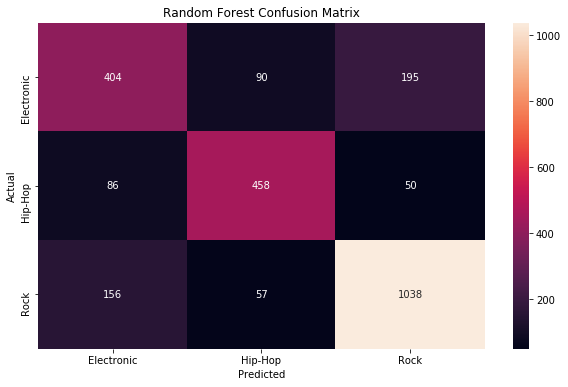

In [20]:
rf = RandomForestClassifier(random_state=4444)
rf.fit(X_train, label_train)
plt.figure(figsize=(10,6))
ax = sns.heatmap(confusion_matrix(label_test, rf.predict(X_test)), 
            xticklabels=['Electronic', 'Hip-Hop', 'Rock'],
            yticklabels=['Electronic', 'Hip-Hop', 'Rock'],
            annot=True,
            fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')

print(accuracy_score(label_test, rf.predict(X_test)))
print(precision_score(label_test, rf.predict(X_test), average='weighted'))
print(recall_score(label_test, rf.predict(X_test), average='weighted'))
print(f1_score(label_test, rf.predict(X_test), average='weighted'))

In [21]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': np.linspace(1, 32, 32, endpoint=True),
    'max_features': list(range(1,X_train.shape[1])),
    'min_samples_leaf': np.linspace(0.1, 0.5, 5, endpoint=True),
    'min_samples_split': np.linspace(0.1, 1.0, 10, endpoint=True),
    'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200]
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, label_train)
print(grid_search.best_params_)

Fitting 3 folds for each of 201600 candidates, totalling 604800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 239 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 645 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 1211 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 1941 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 2831 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 3885 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done 5099 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 6477 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 8015 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 9717 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 11579 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 13605 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 15791 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 18141 tasks   

{'bootstrap': False, 'max_depth': 4.0, 'max_features': 3, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'n_estimators': 8}




Train Model:
0.8538565629228687
0.8540520302624154
0.8538565629228687
0.8501681490076275


Test Model:
0.7679558011049724
0.7631881979465144
0.7679558011049724
0.7612899313670894
              precision    recall  f1-score   support

  Electronic       0.70      0.54      0.61       689
     Hip-Hop       0.80      0.78      0.79       594
        Rock       0.78      0.89      0.83      1251

   micro avg       0.77      0.77      0.77      2534
   macro avg       0.76      0.74      0.74      2534
weighted avg       0.76      0.77      0.76      2534



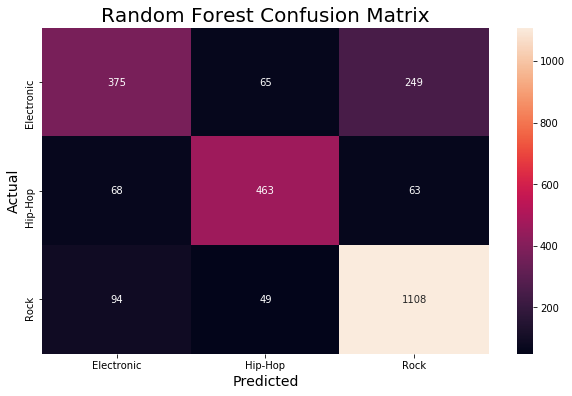

In [25]:
rf = RandomForestClassifier(random_state=4444,
                            bootstrap=False, 
                            max_depth=10,
                            max_features=2, 
                            min_samples_leaf=10, 
                            min_samples_split=12, 
                            n_estimators=30)

#rf = RandomForestClassifier(random_state=4444,
#                            bootstrap=False, 
#                            max_depth=4,
#                            max_features=3, 
#                            min_samples_leaf=0.1, 
#                            min_samples_split=0.1, 
#                            n_estimators=8)
rf.fit(X_train, label_train)
plt.figure(figsize=(10,6))
ax = sns.heatmap(confusion_matrix(label_test, rf.predict(X_test)), 
            xticklabels=['Electronic', 'Hip-Hop', 'Rock'],
            yticklabels=['Electronic', 'Hip-Hop', 'Rock'],
            annot=True,
            fmt='g')
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Random Forest Confusion Matrix', fontsize=20)

print("\n\nTrain Model:")
print(accuracy_score(label_train, rf.predict(X_train)))
print(precision_score(label_train, rf.predict(X_train), average='weighted'))
print(recall_score(label_train, rf.predict(X_train), average='weighted'))
print(f1_score(label_train, rf.predict(X_train), average='weighted'))

print("\n\nTest Model:")
print(accuracy_score(label_test, rf.predict(X_test)))
print(precision_score(label_test, rf.predict(X_test), average='weighted'))
print(recall_score(label_test, rf.predict(X_test), average='weighted'))
print(f1_score(label_test, rf.predict(X_test), average='weighted'))

print(classification_report(label_test, rf.predict(X_test), target_names=['Electronic', 'Hip-Hop', 'Rock']))


## SVC - One VS Rest



Train Model:
0.7745263870094723
0.7721508789394009
0.7745263870094723
0.7636020045702316


Test Model:
0.7375690607734806
0.7329022060340395
0.7375690607734806
0.7253772954658143


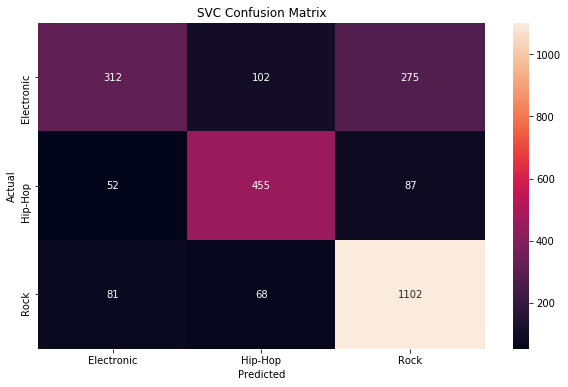

In [171]:
svc = OneVsRestClassifier(SVC(random_state = 4444, probability=True))

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svc.fit(X_train_scaled, label_train)
plt.figure(figsize=(10,6))
ax = sns.heatmap(confusion_matrix(label_test, svc.predict(X_test_scaled)), 
            xticklabels=['Electronic', 'Hip-Hop', 'Rock'],
            yticklabels=['Electronic', 'Hip-Hop', 'Rock'],
            annot=True,
            fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVC Confusion Matrix')

print("\n\nTrain Model:")
print(accuracy_score(label_train, svc.predict(X_train_scaled)))
print(precision_score(label_train, svc.predict(X_train_scaled), average='weighted'))
print(recall_score(label_train, svc.predict(X_train_scaled), average='weighted'))
print(f1_score(label_train, svc.predict(X_train_scaled), average='weighted'))

print("\n\nTest Model:")
print(accuracy_score(label_test, svc.predict(X_test_scaled)))
print(precision_score(label_test, svc.predict(X_test_scaled), average='weighted'))
print(recall_score(label_test, svc.predict(X_test_scaled), average='weighted'))
print(f1_score(label_test, svc.predict(X_test_scaled), average='weighted'))

In [198]:
Cs = [0.01, 0.1, 1, 10, 100]
gammas = [0.001, 0.01, 0.1, 1]
kernels = ['linear','rbf']

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

param_grid = {'estimator__C': Cs, 'estimator__gamma' : gammas, 'estimator__kernel' : kernels}
grid_search = GridSearchCV(OneVsRestClassifier(SVC(random_state = 4444, probability=True)), param_grid, cv=3)
grid_search.fit(X_train_scaled, label_train)
print(grid_search.best_params_)

{'estimator__C': 10, 'estimator__gamma': 0.1, 'estimator__kernel': 'rbf'}




Train Model:
0.8044654939106901
0.8036805535547038
0.8044654939106901
0.7965302743980568


Test Model:
0.7466456195737964
0.7408919586613149
0.7466456195737964
0.7381725716419639


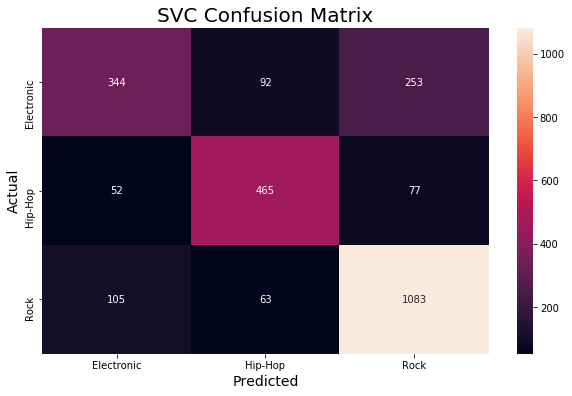

In [208]:
svc = OneVsRestClassifier(SVC(random_state = 4444, probability=True, C=10, gamma=.1, kernel='rbf'))

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svc.fit(X_train_scaled, label_train)
plt.figure(figsize=(10,6))
ax = sns.heatmap(confusion_matrix(label_test, svc.predict(X_test_scaled)), 
            xticklabels=['Electronic', 'Hip-Hop', 'Rock'],
            yticklabels=['Electronic', 'Hip-Hop', 'Rock'],
            annot=True,
            fmt='g')
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('SVC Confusion Matrix', fontsize=20)


print("\n\nTrain Model:")
print(accuracy_score(label_train, svc.predict(X_train_scaled)))
print(precision_score(label_train, svc.predict(X_train_scaled), average='weighted'))
print(recall_score(label_train, svc.predict(X_train_scaled), average='weighted'))
print(f1_score(label_train, svc.predict(X_train_scaled), average='weighted'))

print("\n\nTest Model:")
print(accuracy_score(label_test, svc.predict(X_test_scaled)))
print(precision_score(label_test, svc.predict(X_test_scaled), average='weighted'))
print(recall_score(label_test, svc.predict(X_test_scaled), average='weighted'))
print(f1_score(label_test, svc.predict(X_test_scaled), average='weighted'))

## Logistic Regression

0.7131018153117601
0.7102969743761417
0.7131018153117601
0.6995445558391059


/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


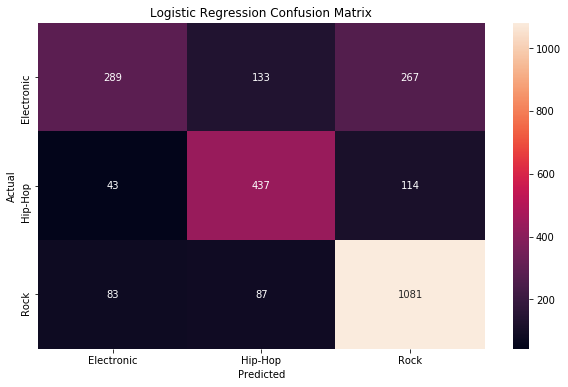

In [184]:
logist = OneVsRestClassifier(LogisticRegression(random_state = 4444))

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logist.fit(X_train_scaled, label_train)
plt.figure(figsize=(10,6))
ax = sns.heatmap(confusion_matrix(label_test, logist.predict(X_test_scaled)), 
            xticklabels=['Electronic', 'Hip-Hop', 'Rock'],
            yticklabels=['Electronic', 'Hip-Hop', 'Rock'],
            annot=True,
            fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')

print(accuracy_score(label_test, logist.predict(X_test_scaled)))
print(precision_score(label_test, logist.predict(X_test_scaled), average='weighted'))
print(recall_score(label_test, logist.predict(X_test_scaled), average='weighted'))
print(f1_score(label_test, logist.predict(X_test_scaled), average='weighted'))

In [94]:
Cs = [0.001, 0.01, 0.1, 1, 10]

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

param_grid = {'estimator__C': Cs}
grid_search = GridSearchCV(OneVsRestClassifier(LogisticRegression(random_state = 4444)), param_grid, cv=3)
grid_search.fit(X_train_scaled, label_train)
print(grid_search.best_params_)

/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

{'estimator__C': 10}


/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hdeva/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)




Train Model:
0.7247970230040596
0.7212148547972048
0.7247970230040596
0.7109067168645217


Test Model:
0.7131018153117601
0.7102969743761417
0.7131018153117601
0.6995445558391059


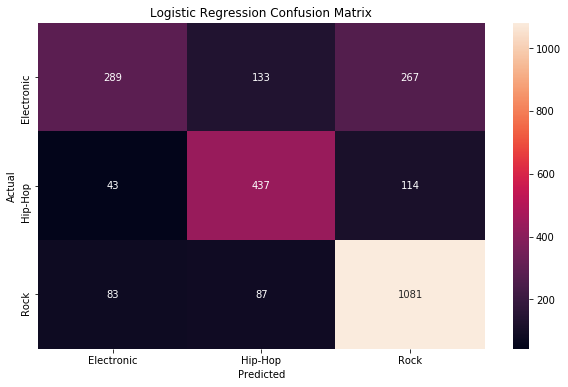

In [186]:
logist = OneVsRestClassifier(LogisticRegression(random_state = 4444, C = 10))

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logist.fit(X_train_scaled, label_train)
plt.figure(figsize=(10,6))
ax = sns.heatmap(confusion_matrix(label_test, logist.predict(X_test_scaled)), 
            xticklabels=['Electronic', 'Hip-Hop', 'Rock'],
            yticklabels=['Electronic', 'Hip-Hop', 'Rock'],
            annot=True,
            fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')

print("\n\nTrain Model:")
print(accuracy_score(label_train, logist.predict(X_train_scaled)))
print(precision_score(label_train, logist.predict(X_train_scaled), average='weighted'))
print(recall_score(label_train, logist.predict(X_train_scaled), average='weighted'))
print(f1_score(label_train, logist.predict(X_train_scaled), average='weighted'))

print("\n\nTest Model:")
print(accuracy_score(label_test, logist.predict(X_test_scaled)))
print(precision_score(label_test, logist.predict(X_test_scaled), average='weighted'))
print(recall_score(label_test, logist.predict(X_test_scaled), average='weighted'))
print(f1_score(label_test, logist.predict(X_test_scaled), average='weighted'))

## Conclusions

In terms of tuning hyperparameters, Random Forest outperformed SVC and Logistic Regression in every metric. Yet, Random Forest overfits while SVC doesn't.

# Model Selection

Optimal Threshold for Class 0.00
(0.5332104271441933, 0.2742589146789204)
Optimal Threshold for Class 1.00
(0.7773244781783681, 0.2646261255084784)
Optimal Threshold for Class 2.00
(0.658406150615988, 0.4746776978999118)


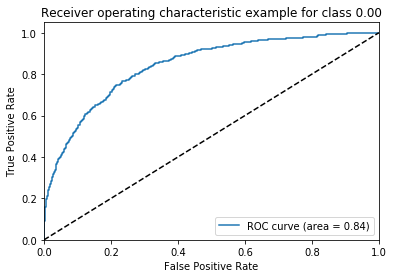

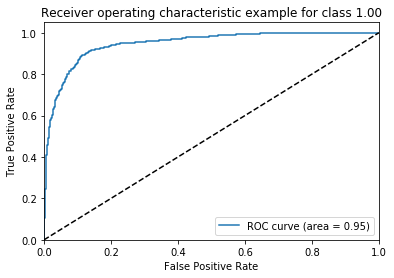

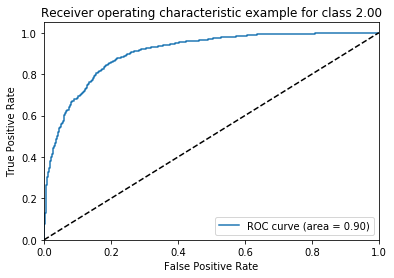

In [34]:
print_roc_curves(RandomForestClassifier(random_state=4444,
                            bootstrap=False, 
                            max_depth=10,
                            max_features=2, 
                            min_samples_leaf=10, 
                            min_samples_split=12, 
                            n_estimators=30), X, label, False)

Optimal Threshold for Class 0.00
(0.5244655614146863, 0.1991743729357196)
Optimal Threshold for Class 1.00
(0.7235294117647059, 0.1719239227077833)
Optimal Threshold for Class 2.00
(0.6505830528710079, 0.48406054247222735)


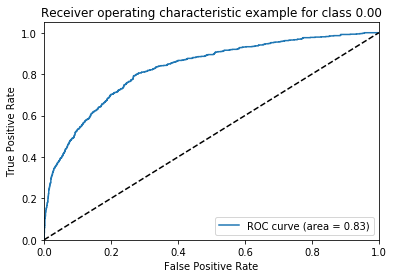

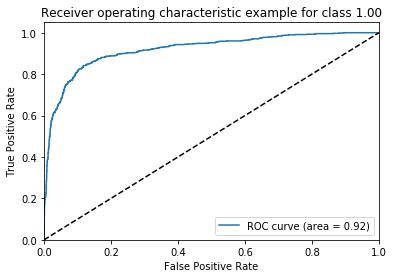

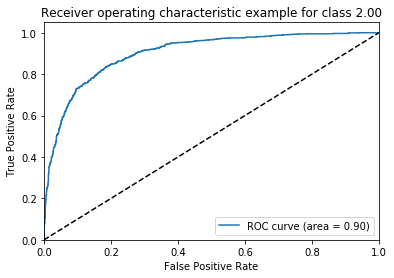

In [35]:
print_roc_curves_standard(OneVsRestClassifier(SVC(random_state = 4444, probability=True, C=10, gamma=.1, kernel='rbf')), X, label, True)

Grid Searched Random Forest has highest AUC Recall, Precision, F1, and Accuracy (which is still valid based on not using resampled data). Grid Searched SVC has the lowest log-loss, but has second highest AUC, Recall, Precision, F1. 

I only care about the final class prediction. So I'll stick to F1. Grid Searched Random Forest had the highest of 0.766, and hyperparameter tuning reduced the overfitting. So I'll stick to Grid Search Random Forest.

# Dump Best Model into Pickle File

In [25]:
X = genre_df[['danceability',
              'energy',
              'speechiness',
              'acousticness',
              'instrumentalness',
              'liveness',
              'valence',
              'tempo']]

label = genre_df['genre']

X_train, X_test, label_train, label_test = train_test_split(X, label, test_size=0.3, random_state=41)

rf = RandomForestClassifier(random_state=4444,
                            bootstrap=False, 
                            max_depth=10,
                            max_features=2, 
                            min_samples_leaf=10, 
                            min_samples_split=12, 
                            n_estimators=30)

rf.fit(X_train, label_train)


filename = 'finalized_model.p'
pickle.dump(rf, open(filename, 'wb'))

Get most important features as part of Random Forest Model

In [48]:
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), X_train.columns)))

[(0.0433, 'liveness'), (0.0738, 'valence'), (0.0791, 'tempo'), (0.094, 'acousticness'), (0.0949, 'energy'), (0.189, 'instrumentalness'), (0.1921, 'speechiness'), (0.2338, 'danceability')]


# Interactive Visualizations

In [7]:
genre_plotly_df = genre_df.groupby('genre').mean().reset_index()
genre_plotly_df

genre  danceability    energy  speechiness  acousticness  \
0  Electronic      0.585293  0.636898     0.103938      0.278695   
1     Hip-Hop      0.666030  0.620086     0.200319      0.247253   
2        Rock      0.414523  0.666193     0.068220      0.422172   

   instrumentalness  liveness   valence       tempo  
0          0.596775  0.178908  0.421412  123.238690  
1          0.124125  0.190894  0.538837  118.872398  
2          0.543398  0.190206  0.423359  128.261440

In [8]:
import plotly.graph_objects as go

categories = ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
  r=genre_plotly_df.loc[1, categories],
  theta=categories,
  fill='toself',
  name='Hip-Hop'
))

fig.add_trace(go.Scatterpolar(
  r=genre_plotly_df.loc[2, categories],
  theta=categories,
  fill='toself',
  name='Rock'
))

fig.add_trace(go.Scatterpolar(
  r=genre_plotly_df.loc[0, categories],
  theta=categories,
  fill='toself',
  name='Electronic'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True
    ),
  ),
  showlegend=True
)

fig.show()

In [9]:
genre_plotly_df.loc[:, ['tempo']].values.flatten()

array([123.23868998, 118.87239764, 128.26143991])

In [15]:
genres=['Electronic', 'Hip-Hop', 'Rock']

fig = go.Figure(go.Bar(x=genres, y=genre_plotly_df.loc[:, ['tempo']].values.flatten()))

fig.update_layout(
    title=go.layout.Title(
        text="Tempo per Genre",
        xref="paper",
        x=0
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Genre",
            font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Tempo",
            font=dict(
                family="Courier New, monospace",
                size=18,
                color="#7f7f7f"
            )
        )
    )
)

fig.show()